# PINN-DSGRN Analysis

This notebook analyzes the results of the PINN-DSGRN experiments.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

sys.path.append('../src')
from utils import plot_training_curves, plot_parameter_distributions, compute_confidence_intervals

In [3]:
# Cell 2: Load results
results = pd.read_csv('../results/experiment_results.csv')
print(f"Total experiments: {len(results)}")
print(f"Data types: {results['data_type'].unique()}")
print(f"Approx types: {results['approx_type'].unique()}")

Total experiments: 120
Data types: ['heaviside' 'hill' 'piecewise']
Approx types: ['hill' 'piecewise']


In [4]:
# Cell 3: Summary statistics
summary = compute_confidence_intervals(results)
print(summary.to_string(index=False))

data_type approx_type  param_0_mean  param_0_std  param_0_ci_lower  param_0_ci_upper  param_1_mean  param_1_std  param_1_ci_lower  param_1_ci_upper  n_runs  mean_final_loss  std_final_loss
heaviside        hill      5.612937     0.407568          5.205369          6.020504      6.304167     0.980601          5.323566          7.284768      20         0.216077        0.008942
heaviside   piecewise      0.299835     0.066029          0.233805          0.365864      0.114737     0.043301          0.071437          0.158038      20         0.195844        0.029851
     hill        hill      5.574651     0.299293          5.275358          5.873944      6.223916     0.971686          5.252230          7.195601      20         0.215761        0.012049
     hill   piecewise      0.287649     0.040382          0.247266          0.328031      0.114793     0.045178          0.069615          0.159972      20         0.207797        0.014209
piecewise        hill      5.636813     0.402030       

In [5]:
# Cell 4: Parameter distribution plots
plot_parameter_distributions(
    results,
    save_path='../results/figures/param_distributions.png'
)

In [6]:
# Cell 5: Representative training curves
# Load and plot a few training curves for each group
for (data_type, approx_type), group in results.groupby(['data_type', 'approx_type']):
    # Pick first 3 runs
    for _, row in group.head(3).iterrows():
        run_id = row['run_id']
        curve_path = Path(f'../results/training_curves/{data_type}_{approx_type}_run{run_id:03d}.csv')
        
        if curve_path.exists():
            hist = pd.read_csv(curve_path)
            plot_training_curves(
                hist,
                save_path=f'../results/figures/curves_{data_type}_{approx_type}_run{run_id:03d}.png',
                title=f'{data_type} → {approx_type} (Run {run_id})'
            )

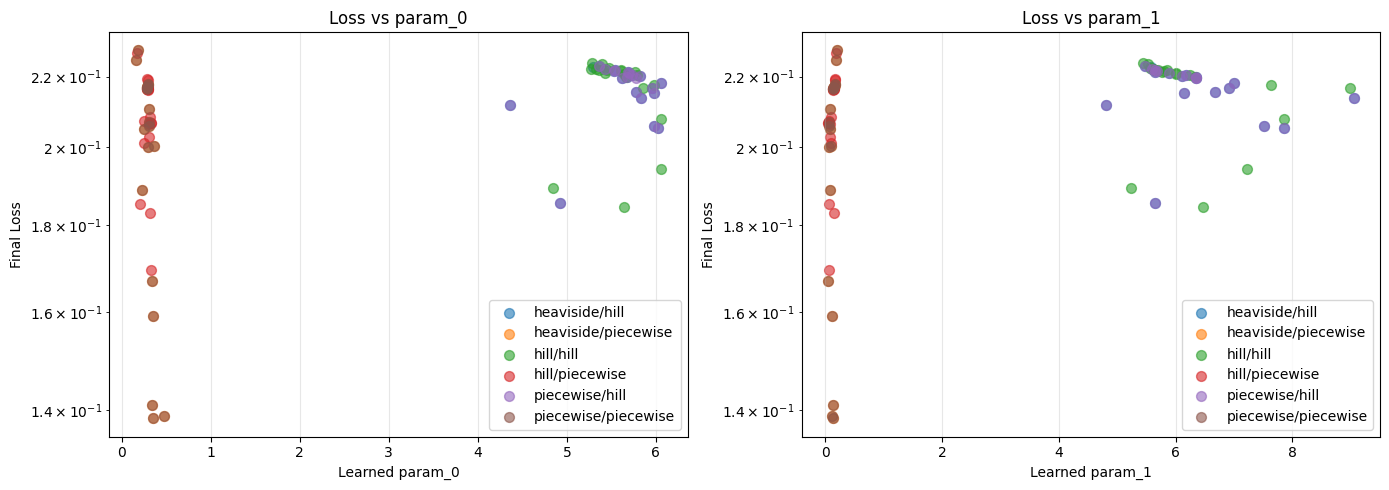

In [7]:
# Cell 6: Loss vs parameters scatter
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, param_name in enumerate(['param_0', 'param_1']):
    ax = axes[i]
    for data_type in results['data_type'].unique():
        for approx_type in results['approx_type'].unique():
            subset = results[
                (results['data_type'] == data_type) &
                (results['approx_type'] == approx_type)
            ]
            ax.scatter(
                subset[param_name],
                subset['final_loss'],
                label=f'{data_type}/{approx_type}',
                alpha=0.6,
                s=50
            )
    ax.set_xlabel(f'Learned {param_name}')
    ax.set_ylabel('Final Loss')
    ax.set_yscale('log')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_title(f'Loss vs {param_name}')

plt.tight_layout()
plt.savefig('../results/figures/loss_vs_params.png', dpi=150)
plt.show()

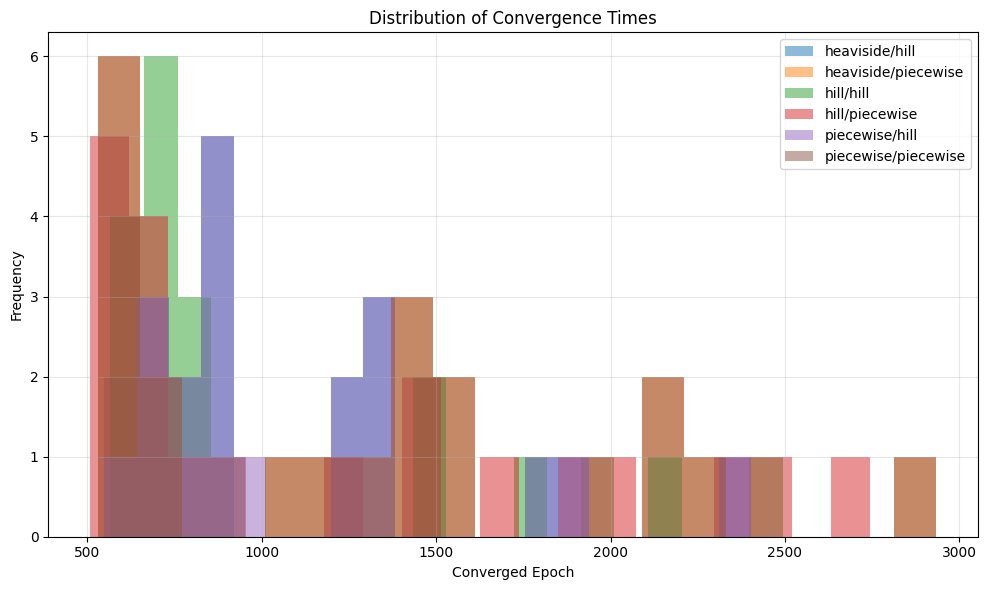

In [8]:
# Cell 7: Convergence analysis
fig, ax = plt.subplots(figsize=(10, 6))
for (data_type, approx_type), group in results.groupby(['data_type', 'approx_type']):
    ax.hist(
        group['converged_epoch'],
        bins=20,
        alpha=0.5,
        label=f'{data_type}/{approx_type}'
    )
ax.set_xlabel('Converged Epoch')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('Distribution of Convergence Times')
plt.tight_layout()
plt.savefig('../results/figures/convergence_histogram.png', dpi=150)
plt.show()